In [1]:
import matplotlib.pyplot as plt
plt.style.use('thesis')
import numpy as np
from sklearn.metrics import mean_squared_error

from pyght.src.sfh import SFH

In [2]:
spec = SFH(0.1 * np.ones((1,10)))

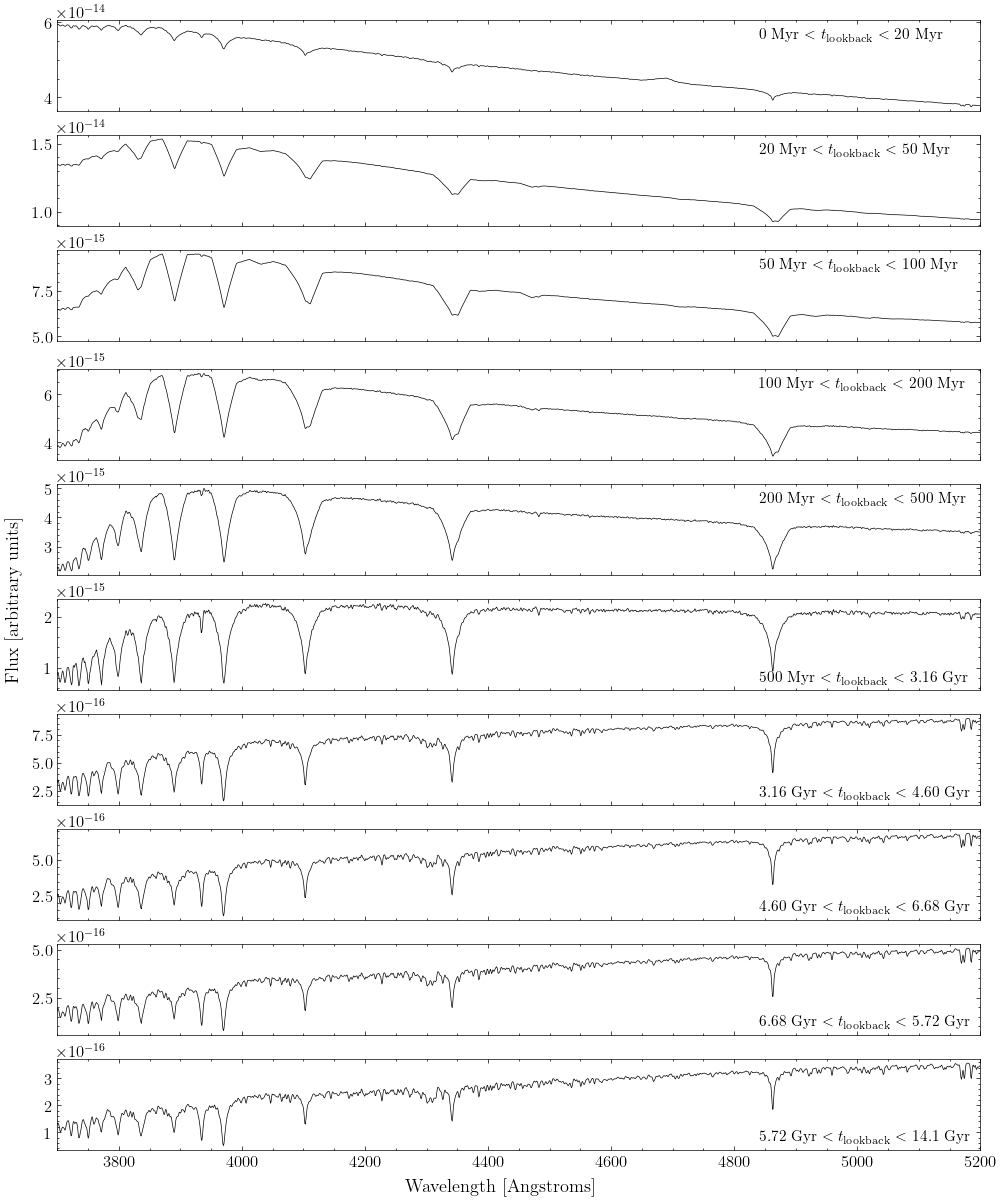

In [3]:
avgs = spec.get_averages()
vals = list(avgs.values())

fig, ax = plt.subplots(10, 1, figsize=(10,12), sharex=True, constrained_layout=True)
for i, s in enumerate(vals):
    ax[i].plot(spec.wav, s, 'k', linewidth=0.5)

ax[0].text(0.76, 0.8, '0 Myr $<t_\mathrm{lookback}<$ 20 Myr', transform=ax[0].transAxes)
ax[1].text(0.76, 0.8, '20 Myr $<t_\mathrm{lookback}<$ 50 Myr', transform=ax[1].transAxes)
ax[2].text(0.76, 0.8, '50 Myr $<t_\mathrm{lookback}<$ 100 Myr', transform=ax[2].transAxes)
ax[3].text(0.76, 0.8, '100 Myr $<t_\mathrm{lookback}<$ 200 Myr', transform=ax[3].transAxes)
ax[4].text(0.76, 0.8, '200 Myr $<t_\mathrm{lookback}<$ 500 Myr', transform=ax[4].transAxes)
ax[5].text(0.76, 0.1, '500 Myr $<t_\mathrm{lookback}<$ 3.16 Gyr', transform=ax[5].transAxes)
ax[6].text(0.76, 0.1, '3.16 Gyr $<t_\mathrm{lookback}<$ 4.60 Gyr', transform=ax[6].transAxes)
ax[7].text(0.76, 0.1, '4.60 Gyr $<t_\mathrm{lookback}<$ 6.68 Gyr', transform=ax[7].transAxes)
ax[8].text(0.76, 0.1, '6.68 Gyr $<t_\mathrm{lookback}<$ 5.72 Gyr', transform=ax[8].transAxes)
ax[9].text(0.76, 0.1, '5.72 Gyr $<t_\mathrm{lookback}<$ 14.1 Gyr', transform=ax[9].transAxes)

ax[0].set_xlim(3700,5200)
fig.supylabel('Flux [arbitrary units]')
fig.supxlabel('Wavelength [Angstroms]')

plt.savefig('thesis/figures/sfh_averages.pdf', format='pdf')
plt.show()

In [5]:
root = "sfh_100_10_20251102_130203"
real_spec = np.load(f"/data/mustard/vmehta/{root}/{root}_snr_spectra.npy")
real_sfh = np.load(f"/data/mustard/vmehta/{root}/snr__all_true.npy")
wav = np.load(f"/data/mustard/vmehta/{root}/{root}_wavelength.npy")

# Bin setup (used in multiple places)
bin_arr = np.r_[np.array([0.1, 20, 50, 100, 200, 500])*1e6, np.logspace(9.5, 10.15, 5)]
binning = np.log10(bin_arr)
bin_widths = np.diff(binning)
bin_centers = binning[:-1] + bin_widths/2

def load_noisy_data(snr, NoisyTraining=False):
    if NoisyTraining:
        pred_sfh = np.load(f"/data/mustard/vmehta/{root}/noisy_training/snr_{snr}_all_pred.npy")
    else:
        if snr == None:
            pred_sfh = np.load(f"/data/mustard/vmehta/{root}/snr__all_pred.npy")
        else:
            pred_sfh = np.load(f"/data/mustard/vmehta/{root}/noiseless_training/snr_{snr}_all_pred.npy")
    return pred_sfh

# noiseless predictions
snrNone = load_noisy_data(None)

def rmse(pred_sfh):
    rmse = np.sqrt(mean_squared_error(real_sfh, pred_sfh, multioutput='raw_values'))
    overall_rmse = np.sqrt(mean_squared_error(real_sfh, pred_sfh))
    return rmse, overall_rmse

def plot_sfh(snr, n):
    plt.figure(figsize=(10,5))
    plt.bar(bin_centers, real_sfh[n], width=bin_widths, alpha=0.5, label='True SFH', color='grey', edgecolor='black')
    plt.bar(bin_centers, snr[n], width=bin_widths, alpha=0.3, label='Predicted SFH', color='red', edgecolor='red')
    plt.bar(bin_centers, snrNone[n], width=bin_widths, alpha=0.3, label='Predicted SFH (No Noise)', color='blue', edgecolor='blue')
    plt.xlabel('Log Age (years)')
    plt.ylabel('f')
    plt.title(f'Star Formation History Comparison (n={n})')
    plt.legend()
    plt.show()

def plot_diff(snr):

    diff = snr - real_sfh
    nonoise_diff = snrNone - real_sfh

    median = np.median(diff, axis=0)
    sixteen = np.percentile(diff, 16, axis=0)
    eightyfour = np.percentile(diff, 84, axis=0)

    median_nonoise = np.median(nonoise_diff, axis=0)
    sixteen_nonoise = np.percentile(nonoise_diff, 16, axis=0)
    eightyfour_nonoise = np.percentile(nonoise_diff, 84, axis=0)

    plt.figure(figsize=(10,5))
    plt.errorbar(bin_centers, median, yerr=[median - sixteen, eightyfour - median], fmt='o', capsize=5, label=f'Noisy')
    plt.errorbar(bin_centers, median_nonoise, yerr=[median_nonoise - sixteen_nonoise, eightyfour_nonoise - median_nonoise], fmt='o', capsize=5, label='No Noise')
    plt.xlabel('log(Age)')
    plt.ylabel('Difference (pred - true)')
    plt.xlim(2.5,10.5)
    plt.legend()
    plt.show()

In [6]:
snr500 = load_noisy_data(500)
snr250 = load_noisy_data(250)
snr100 = load_noisy_data(100)
snr50 = load_noisy_data(50)
snr25 = load_noisy_data(25)
snr10 = load_noisy_data(10)

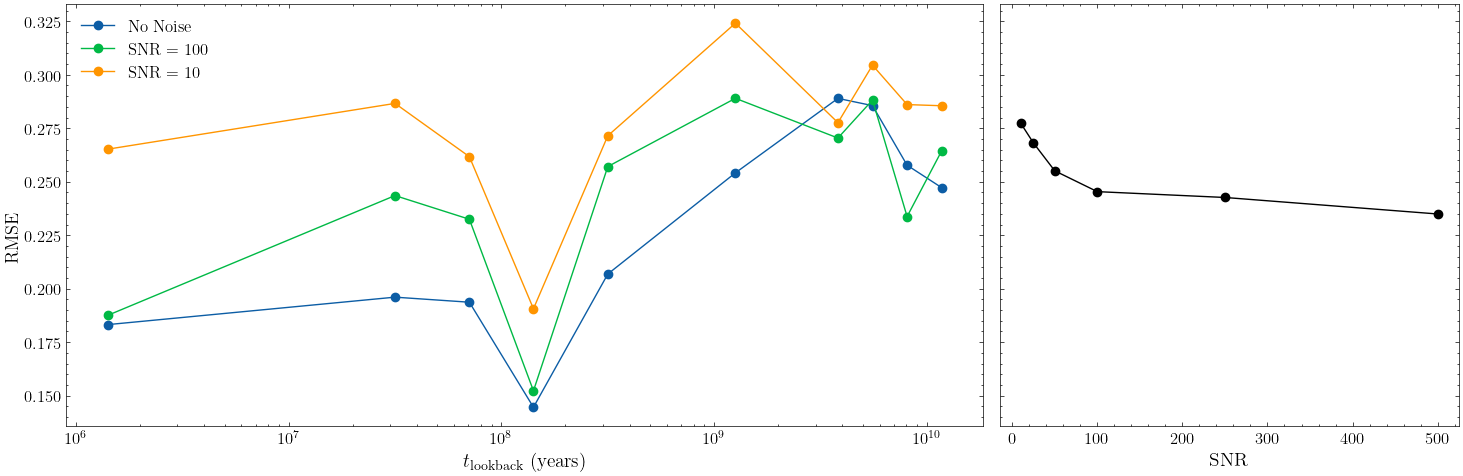

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [2, 1]})

ax[0].semilogx(10**(bin_centers), rmse(snrNone)[0], marker='o')
for s in [snr100, snr10]:
    ax[0].semilogx(10**(bin_centers), rmse(s)[0], marker='o')
ax[0].set_xlabel('$t_\mathrm{lookback}$ (years)')
ax[0].legend(labels=['No Noise', 'SNR = 100', 'SNR = 10'])

ax[1].plot(np.array([500, 250, 100, 50, 25, 10]), [rmse(snr500)[1], rmse(snr250)[1], rmse(snr100)[1], rmse(snr50)[1], rmse(snr25)[1], rmse(snr10)[1]], 'ko-')
ax[1].set_xlabel('SNR')

fig.supylabel('RMSE')
plt.tight_layout()
plt.show()

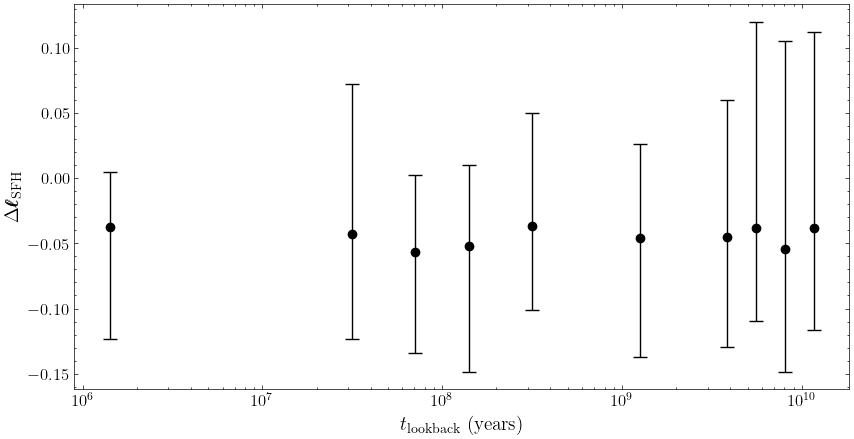

In [8]:
diff = snrNone - real_sfh

median = np.median(diff, axis=0)
sixteen = np.percentile(diff, 16, axis=0)
eightyfour = np.percentile(diff, 84, axis=0)

plt.figure(figsize=(10,5))
plt.errorbar(10**(bin_centers), median, yerr=[median - sixteen, eightyfour - median], fmt='ok', capsize=5)
plt.xlabel('$t_\\mathrm{lookback}$ (years)')
plt.ylabel('$\Delta\pmb{\ell}_\mathrm{SFH}$')
plt.xscale('log')
plt.show()